In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pickle
import operator
from pylab import *

In [3]:
import sys
sys.path.append("/opt/conda/lib/python3.7/site-packages") ##添加xbg路径

In [64]:
from sklearn.model_selection import StratifiedKFold, train_test_split,cross_val_score
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, RocCurveDisplay,auc
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [5]:
print(sys.version)

3.7.10 | packaged by conda-forge | (default, Oct  5 2021, 17:08:41) 
[GCC 9.4.0]


NEWWWWWWWWWWWWWWWWWWWW

In [6]:
name = []
for i in range(0,40):
    if i < 10:
        string = "data/part-0000"+str(i)+"-69c2d441-479f-4b36-90cc-4a4dd22af768-c000.csv"
    else:
        string = "data/part-000"+str(i)+"-69c2d441-479f-4b36-90cc-4a4dd22af768-c000.csv"
    name.append(string)

In [7]:
df = pd.concat(
    map(pd.read_csv, name), ignore_index=True)

In [8]:
df1=df.drop(['account_code','accnt_id','accnt_name','social_credit_num','created'], axis=1)

In [9]:
import woe.feature_process as fp
import woe.eval as eval

In [10]:
df1.rename(columns={"flag": "target"}, inplace=True)

In [11]:
df1=df1.fillna(0)

In [12]:
df1

,customer_wid,regist_capital,unit_level,act_category,act_alias,ent_category,ent_level,industry,accnt_type,kq1j,...,zps_endtrial_15_uv,zps_endtrial_30_uv,zps_endtrial_60_uv,zps_endtrial_120_uv,lock_cnt_gtj,jkzh_ab,sgd_ab,zps_ab,jkzh_gjg,target
0,23298556,300.0,部门级,普通咨询,中型咨询,中小型用户,中型咨询,房建,中介,设计与成本客户群,...,0.0,0.0,0.0,0.0,24.0,0.0,19.0,19.0,19.0,0.0
1,23497105,0.0,个人,0,0,中小型用户,0,房建,个人,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,27670062,8000.0,集团/总部/局,0,0,中小型用户,施工散户-土建,请选择,施工散户,设计与成本客户群,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0
3,30242442,0.0,个人,普通咨询,小型咨询,中小型用户,小型咨询,房建,个人,设计与成本客户群,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,23353429,11200.0,公司级,0,0,中小型用户,施工散户-土建,房建,施工散户,设计与成本客户群,...,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149709,23461397,0.0,集团/总部/局,0,0,中小型用户,自建甲方,房建,其他甲方-临建甲方,设计与成本客户群,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0
149710,49181121,100.0,集团/总部/局,普通咨询,小型咨询,中小型用户,小型咨询,房建,中介,设计与成本客户群,...,0.0,0.0,0.0,0.0,5.0,0.0,3.0,5.0,3.0,0.0
149711,23716421,20100.0,个人,0,0,中小型用户,其他,请选择,个人,设计与成本客户群,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
149712,23557193,5000.0,公司级,0,0,中小型用户,施工散户-土建,房建,施工散户,设计与成本客户群,...,0.0,0.0,0.0,0.0,4.0,0.0,2.0,2.0,1.0,0.0


In [13]:
df1[['unit_level','act_category','act_alias','ent_level','kq1j','ent_category']]=df1[['unit_level','act_category','act_alias','ent_level','kq1j','ent_category']].astype(str)

In [14]:
df2 = df1.copy()

In [16]:
train, test = train_test_split(df2, test_size=0.2, random_state=1)
train2 = train.copy()

In [17]:
data_woe = train2 #用于存储所有数据的woe值
civ_list = []
n_positive = sum(train2['target'])
n_negtive = len(train2) - n_positive
for column in list(train2.columns[1:-1]):
    if train2[column].dtypes == 'object':
        civ = fp.proc_woe_discrete(train2, column, n_positive, n_negtive, 0.05*len(train2), alpha=0.05)
    else:  
        civ = fp.proc_woe_continuous(train2, column, n_positive, n_negtive, 0.05*len(train2), alpha=0.05)
    civ_list.append(civ)
    data_woe[column] = fp.woe_trans(train2[column], civ)

civ_df = eval.eval_feature_detail(civ_list,'train_output.csv')

---------process continuous variable:regist_capital---------
------------process discrete variable:unit_level------------


/opt/conda/lib/python3.7/site-packages/woe/feature_process.py:414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var] = cpvar


-----------process discrete variable:act_category-----------
------------process discrete variable:act_alias-------------
-----------process discrete variable:ent_category-----------
------------process discrete variable:ent_level-------------
-------------process discrete variable:industry-------------
------------process discrete variable:accnt_type------------
---------------process discrete variable:kq1j---------------
--------------process discrete variable:branch--------------
------------process discrete variable:management------------
--------process continuous variable:jkzh_work_15_pv---------
--------process continuous variable:jkzh_work_30_pv---------
--------process continuous variable:jkzh_work_60_pv---------
--------process continuous variable:jkzh_work_120_pv--------
--------process continuous variable:jkzh_work_15_uv---------
--------process continuous variable:jkzh_work_30_uv---------
--------process continuous variable:jkzh_work_60_uv---------
--------process continuo

In [18]:
train2

,customer_wid,regist_capital,unit_level,act_category,act_alias,ent_category,ent_level,industry,accnt_type,kq1j,...,zps_endtrial_15_uv,zps_endtrial_30_uv,zps_endtrial_60_uv,zps_endtrial_120_uv,lock_cnt_gtj,jkzh_ab,sgd_ab,zps_ab,jkzh_gjg,target
97686,649669366,-0.100295,0.006401,-0.330385,-0.243268,-0.122040,0.033216,-0.021283,-0.219160,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,-0.250531,-0.040303,-0.085208,-0.178113,-0.285042,0.0
6540,23126589,-0.126418,0.006401,-0.330385,-0.243268,-0.122040,-0.497266,-0.021283,-0.219160,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,-0.250531,-0.040303,-0.085208,-0.178113,-0.285042,0.0
5965,602876318,-0.177438,-0.072316,-0.330385,-0.243268,-0.122040,0.337307,-0.021283,0.520167,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,-0.752347,-0.040303,-0.085208,-0.178113,-0.257799,0.0
51466,23357444,-0.100295,0.006401,0.323977,0.459027,-0.122040,0.972600,-0.021283,0.520167,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,0.462536,-0.040303,0.562171,-0.178113,0.764229,1.0
30367,104797075,-0.126418,0.390941,0.323977,1.193099,0.694139,-0.610092,-0.021283,-0.219160,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,-0.397463,-0.040303,0.562171,-0.114941,-0.285042,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73349,23467658,-0.126418,0.006401,-0.330385,-0.243268,-0.122040,-0.159455,-0.021283,-0.219160,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,-0.752347,-0.040303,-0.085208,-0.178113,-0.285042,0.0
109259,165380962,-0.126418,-0.072316,-0.330385,-0.243268,-0.122040,-0.497266,-0.021283,-0.219160,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,-0.038559,-0.040303,-0.085208,-0.178113,-0.285042,0.0
50057,136081592,-0.177438,0.322858,-0.330385,-0.243268,-0.122040,-0.159455,-0.021283,-0.219160,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,-0.397463,-0.040303,-0.530917,-0.577448,-0.285042,0.0
5192,649647766,-0.177438,0.006401,0.323977,-0.243268,-0.122040,0.033216,-0.021283,-0.219160,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,-0.752347,-0.040303,-0.530917,-0.577448,-0.285042,1.0


## hyper-parameter tuning

In [1]:
from time import time
import scipy.stats as stats
import gc

from bayes_opt import BayesianOptimization

from sklearn.model_selection import cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import log_loss, matthews_corrcoef, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import contextlib

In [19]:
#导入训练数据
X_train=train2.drop(['target','customer_wid'],axis=1)
Y_train=train2['target']

In [71]:
def xgb_cv(n_estimators, max_depth, learning_rate, subsample, min_child_weight, colsample_bytree):
    val = cross_val_score(
        XGBClassifier(n_estimators=int(n_estimators),
            learning_rate=min(learning_rate,0.1),
            subsample=min(subsample, 0.9), 
            max_depth=int(max_depth),
            min_child_weight = min(min_child_weight, 0.999),
            colsample_bytree = min(colsample_bytree, 1.0),
            random_state=1
        ),
        X_train, Y_train, scoring='roc_auc', cv=5
    ).mean()
    return val

In [72]:
XGB_BO = BayesianOptimization(xgb_cv, {
                                        'n_estimators':(100,300),
                                        'max_depth':(2,12),
                                        'learning_rate':(0.01,0.1),
                                        'subsample':(0.7,0.9),
                                        'min_child_weight' : (0,5),
                                        'colsample_bytree':(0.4,1.0)
                                        
                                    })

In [73]:
XGB_BO.maximize()

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.7249    | 0.9742    | 0.04386   | 6.557     | 0.1607    | 175.2     | 0.8688    |
| 2         | 0.7192    | 0.4845    | 0.09144   | 7.958     | 0.7764    | 156.9     | 0.7599    |
| 3         | 0.6961    | 0.6785    | 0.09024   | 10.49     | 1.009     | 192.0     | 0.7591    |
| 4         | 0.7194    | 0.9597    | 0.02788   | 11.37     | 0.6455    | 254.0     | 0.8942    |
| 5         | 0.7222    | 0.455     | 0.08745   | 6.717     | 0.07417   | 189.1     | 0.7823    |
| 6         | 0.7212    | 0.8943    | 0.0739    | 4.318     | 2.036     | 117.8     | 0.8516    |
| 7         | 0.7202    | 0.8716    | 0.01098   | 7.292     | 2.893     | 247.9     | 0.8274    |
| 8         | 0.7207    | 0.7438    | 0.07459   | 3.971     | 2.514     | 239.4     | 0.7053    |
| 9         | 0.7202

In [77]:
XGB_BO.max

{'target': 0.725688726242381,
 'params': {'colsample_bytree': 0.5807348904652786,
  'learning_rate': 0.038505542008962376,
  'max_depth': 7.927625735113134,
  'min_child_weight': 1.1363225229760199,
  'n_estimators': 175.75797838978178,
  'subsample': 0.899631468100033}}

In [89]:
#返回最优的训练器
best_estimator = XGBClassifier(colsample_bytree = 0.5807348904652786,
                                learning_rate = 0.038505542008962376,
                                max_depth = 8,
                                min_child_weight = 1.1363225229760199,
                                n_estimators = 176,
                                subsample = 0.899631468100033)

In [90]:
best_estimator.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5807348904652786, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.038505542008962376,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=8,
              max_leaves=0, min_child_weight=1.1363225229760199, missing=nan,
              monotone_constraints='()', n_estimators=176, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [90]:
######保存
#best_estimator.save_model("model1.ubj")

## TEST

In [91]:
test2 = test.copy()

In [92]:
a = test2
i=0
for column in list(test2.columns[1:-1]):
    a[column]=fp.woe_trans(test2[column], civ_list[i])
    i += 1

In [84]:
test2

,customer_wid,regist_capital,unit_level,act_category,act_alias,ent_category,ent_level,industry,accnt_type,kq1j,...,zps_endtrial_15_uv,zps_endtrial_30_uv,zps_endtrial_60_uv,zps_endtrial_120_uv,lock_cnt_gtj,jkzh_ab,sgd_ab,zps_ab,jkzh_gjg,target
147106,23367453,0.309750,0.006401,0.323977,0.459027,-0.122040,0.337307,-0.021283,0.520167,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,0.462536,-0.040303,0.562171,0.763257,0.764229,0.0
148149,649667388,-0.100295,-0.072316,-0.330385,-0.243268,-0.122040,0.033216,-0.021283,-0.219160,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,-0.250531,-0.040303,-0.085208,-0.178113,-0.285042,0.0
58310,23971986,-0.177438,-0.750887,-0.330385,-0.243268,-0.122040,-0.942085,-0.021283,-0.808420,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,-0.752347,-0.040303,-0.085208,-0.178113,-0.285042,0.0
54576,23210300,0.132119,0.390941,-0.330385,-0.243268,-0.122040,-0.159455,-0.021283,-0.219160,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,0.462536,-0.040303,-0.085208,-0.178113,-0.285042,0.0
104924,28183396,-0.126418,-0.072316,-0.330385,-0.243268,-0.122040,-0.351204,-0.021283,-0.219160,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,-0.752347,-0.040303,-0.085208,-0.178113,-0.285042,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66698,23480955,0.056154,-0.072316,-0.330385,-0.243268,-0.122040,-0.159455,-0.021283,-0.219160,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,-0.250531,-0.040303,-0.085208,-0.178113,-0.285042,0.0
76992,23276630,0.309750,0.322858,0.323977,-0.243268,0.694139,-0.351204,-0.021283,-0.219160,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,-0.752347,-0.040303,-0.085208,-0.178113,-0.257799,0.0
113549,649635132,-0.177438,0.006401,-0.330385,-0.243268,-0.122040,0.033216,-0.021283,-0.219160,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,-0.250531,-0.040303,-0.085208,-0.178113,-0.285042,0.0
63980,26908104,0.283548,0.322858,0.323977,0.459027,0.694139,0.337307,-0.021283,0.841469,1.265854e-08,...,-0.001536,-0.002596,-0.002851,-0.002552,0.462536,-0.040303,0.562171,-0.178113,0.764229,0.0


In [93]:
X_test=test2.drop(['target','customer_wid'],axis=1)
Y_test=test2['target']

In [94]:
Y_test_pred = best_estimator.predict_proba(X_test)

In [95]:
Y_test_pred_1 = Y_test_pred[:,1]

In [96]:
###最佳阈值
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point

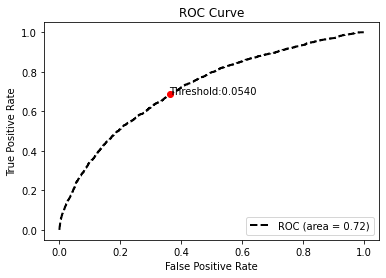

In [97]:
###ROC
fpr, tpr, thersholds = roc_curve(Y_test, Y_test_pred_1, pos_label=1)
best_thershold, point = Find_Optimal_Cutoff(tpr, fpr, thersholds)
roc_auc = auc(fpr, tpr)
 
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
 
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.plot(point[0], point[1], marker='o', color='r')
plt.text(point[0], point[1], f'Threshold:{best_thershold:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")

In [98]:
roc_auc

0.7198524748083964

In [99]:
ks_df = pd.DataFrame()
ks_df['score']=Y_test_pred_1
ks_df['label']=list(Y_test)

In [100]:
### KS
sns.set()
def ks(df, y_true, y_pre, num=10, good=1, bad=0):
    # 1.将数据从小到大平均分成num组
    df_ks = df.sort_values(y_pre).reset_index(drop=True)
    df_ks['rank'] = np.floor((df_ks.index / len(df_ks) * num) + 1)
    df_ks['set_1'] = 1
    # 2.统计结果
    result_ks = pd.DataFrame()
    result_ks['group_sum'] = df_ks.groupby('rank')['set_1'].sum()
    result_ks['group_min'] = df_ks.groupby('rank')[y_pre].min()
    result_ks['group_max'] = df_ks.groupby('rank')[y_pre].max()
    result_ks['group_mean'] = df_ks.groupby('rank')[y_pre].mean()
    # 3.最后一行添加total汇总数据
    result_ks.loc['total', 'group_sum'] = df_ks['set_1'].sum()
    result_ks.loc['total', 'group_min'] = df_ks[y_pre].min()
    result_ks.loc['total', 'group_max'] = df_ks[y_pre].max()
    result_ks.loc['total', 'group_mean'] = df_ks[y_pre].mean()
    # 4.好用户统计
    result_ks['good_sum'] = df_ks[df_ks[y_true] == good].groupby('rank')['set_1'].sum()
    result_ks.good_sum.replace(np.nan, 0, inplace=True)
    result_ks.loc['total', 'good_sum'] = result_ks['good_sum'].sum()
    result_ks['good_percent'] = result_ks['good_sum'] / result_ks.loc['total', 'good_sum']
    result_ks['good_percent_cum'] = result_ks['good_sum'].cumsum() / result_ks.loc['total', 'good_sum']
    # 5.坏用户统计
    result_ks['bad_sum'] = df_ks[df_ks[y_true] == bad].groupby('rank')['set_1'].sum()
    result_ks.bad_sum.replace(np.nan, 0, inplace=True)
    result_ks.loc['total', 'bad_sum'] = result_ks['bad_sum'].sum()
    result_ks['bad_percent'] = result_ks['bad_sum'] / result_ks.loc['total', 'bad_sum']
    result_ks['bad_percent_cum'] = result_ks['bad_sum'].cumsum() / result_ks.loc['total', 'bad_sum']
    # 6.计算ks值
    result_ks['diff'] = result_ks['bad_percent_cum'] - result_ks['good_percent_cum']
    # 7.更新最后一行total的数据
    result_ks.loc['total', 'bad_percent_cum'] = np.nan
    result_ks.loc['total', 'good_percent_cum'] = np.nan
    result_ks.loc['total', 'diff'] = result_ks['diff'].max()
    
    result_ks = result_ks.reset_index()
    
    return result_ks

In [101]:
def ks_curve(df, num=10):
    # 防止中文乱码
    #plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False

    ks_value = df['diff'].max()
    # 获取绘制曲线所需要的数据
    x_curve = range(num + 1)
    y_curve1 = [0] + list(df['bad_percent_cum'].values[:-1])
    y_curve2 = [0] + list(df['good_percent_cum'].values[:-1])
    y_curve3 = [0] + list(df['diff'].values[:-1])
    # 获取绘制ks点所需要的数据
    df_ks_max = df[df['diff'] == ks_value]
    x_point = [df_ks_max['rank'].values[0], df_ks_max['rank'].values[0]]
    y_point = [df_ks_max['bad_percent_cum'].values[0], df_ks_max['good_percent_cum'].values[0]]
    # 绘制曲线
    plt.plot(x_curve, y_curve1, label='bad', linewidth=2)
    plt.plot(x_curve, y_curve2, label='good', linewidth=2)
    plt.plot(x_curve, y_curve3, label='diff', linewidth=2)
    # 标记ks
    plt.plot(x_point, y_point, label='ks - {:.2f}'.format(ks_value), color='r', marker='o', markerfacecolor='r', markersize=5)
    plt.scatter(x_point, y_point, color='r')
    plt.title('K-S')
    plt.legend()
    plt.show()
    
    return ks_value

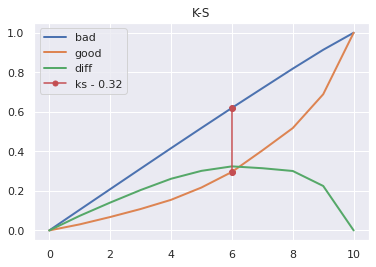

0.32400791621926084

In [102]:
result_ks = ks(ks_df, 'label', 'score')
ks_curve(result_ks)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

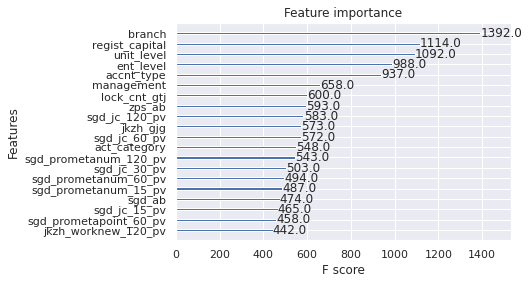

In [103]:
xgb.plot_importance(best_estimator,max_num_features=20)

In [104]:
weight = pd.Series(best_estimator.get_booster().get_score(importance_type='weight')).sort_values(ascending=False).head(20)
weight

branch                    1392.0
regist_capital            1114.0
unit_level                1092.0
ent_level                  988.0
accnt_type                 937.0
management                 658.0
lock_cnt_gtj               600.0
zps_ab                     593.0
sgd_jc_120_pv              583.0
jkzh_gjg                   573.0
sgd_jc_60_pv               572.0
act_category               548.0
sgd_prometanum_120_pv      543.0
sgd_jc_30_pv               503.0
sgd_prometanum_60_pv       494.0
sgd_prometanum_15_pv       487.0
sgd_ab                     474.0
sgd_jc_15_pv               465.0
sgd_prometapoint_60_pv     458.0
jkzh_worknew_120_pv        442.0
dtype: float64